In [1]:
import sys
sys.path.append('./')  # Adjust the path based on your project structure
from SCFpyr import SCFpyr
import torch


In [2]:
import os
import numpy as np
import skimage
import matplotlib.pyplot as plt
import torch
import torchvision

################################################################################

ToPIL = torchvision.transforms.ToPILImage()
Grayscale = torchvision.transforms.Grayscale()
RandomCrop = torchvision.transforms.RandomCrop


def load_image(image_file):
    if isinstance(image_file, str):
        if not os.path.isfile(image_file):
            raise FileNotFoundError('Image file not found on disk: {}'.format(image_file))
        im = ToPIL(skimage.io.imread(image_file))
    else:
        im = image_file
    im = Grayscale(im)
    
    image_size = im.size
    
    im_batch = np.zeros((1, 1, image_size[1], image_size[0]), np.float32)        
    im_batch[0,0,:,:] = im
    # insert channels dim and rescale
    return im_batch[:,:,:,:]/225.

/home/jonathanalis/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jonathanalis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
############################################################################
# Build the complex steerable pyramid
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pyr = SCFpyr(
    height=5, #levels 
    nbands=4,
    scale_factor=2, 
    device = device
)

############################################################################
# Create a batch and feed-forward
im_batch_numpy = load_image('./data/lena.jpg')

im_batch_torch = torch.from_numpy(im_batch_numpy).to(device)
import torch.nn.functional as F
output_height, output_width = 128,173
output_height, output_width = 128, 200
im_batch_torch = F.interpolate(im_batch_torch, 
                               size=(output_height, output_width), 
                               mode='bilinear', 
                               align_corners=False)

im_batch_torch = im_batch_torch.repeat(5, 1, 1, 1)
print(im_batch_torch.shape)
print(im_batch_numpy.shape)


torch.Size([5, 1, 128, 200])
(1, 1, 600, 600)


In [4]:
coeffs = pyr.build(im_batch_torch)
pyr.summary(coeffs)

Levels:  3
Height:  5
Num bands:  4
Scale factor:  2
torch.Size([5, 128, 200])
Level 1:
torch.Size([5, 128, 200]), torch.Size([5, 128, 200]), torch.Size([5, 128, 200]), torch.Size([5, 128, 200]), 
Level 2:
torch.Size([5, 64, 100]), torch.Size([5, 64, 100]), torch.Size([5, 64, 100]), torch.Size([5, 64, 100]), 
Level 3:
torch.Size([5, 32, 50]), torch.Size([5, 32, 50]), torch.Size([5, 32, 50]), torch.Size([5, 32, 50]), 
torch.Size([5, 16, 25])


In [5]:
rec = pyr.reconstruct(coeffs)

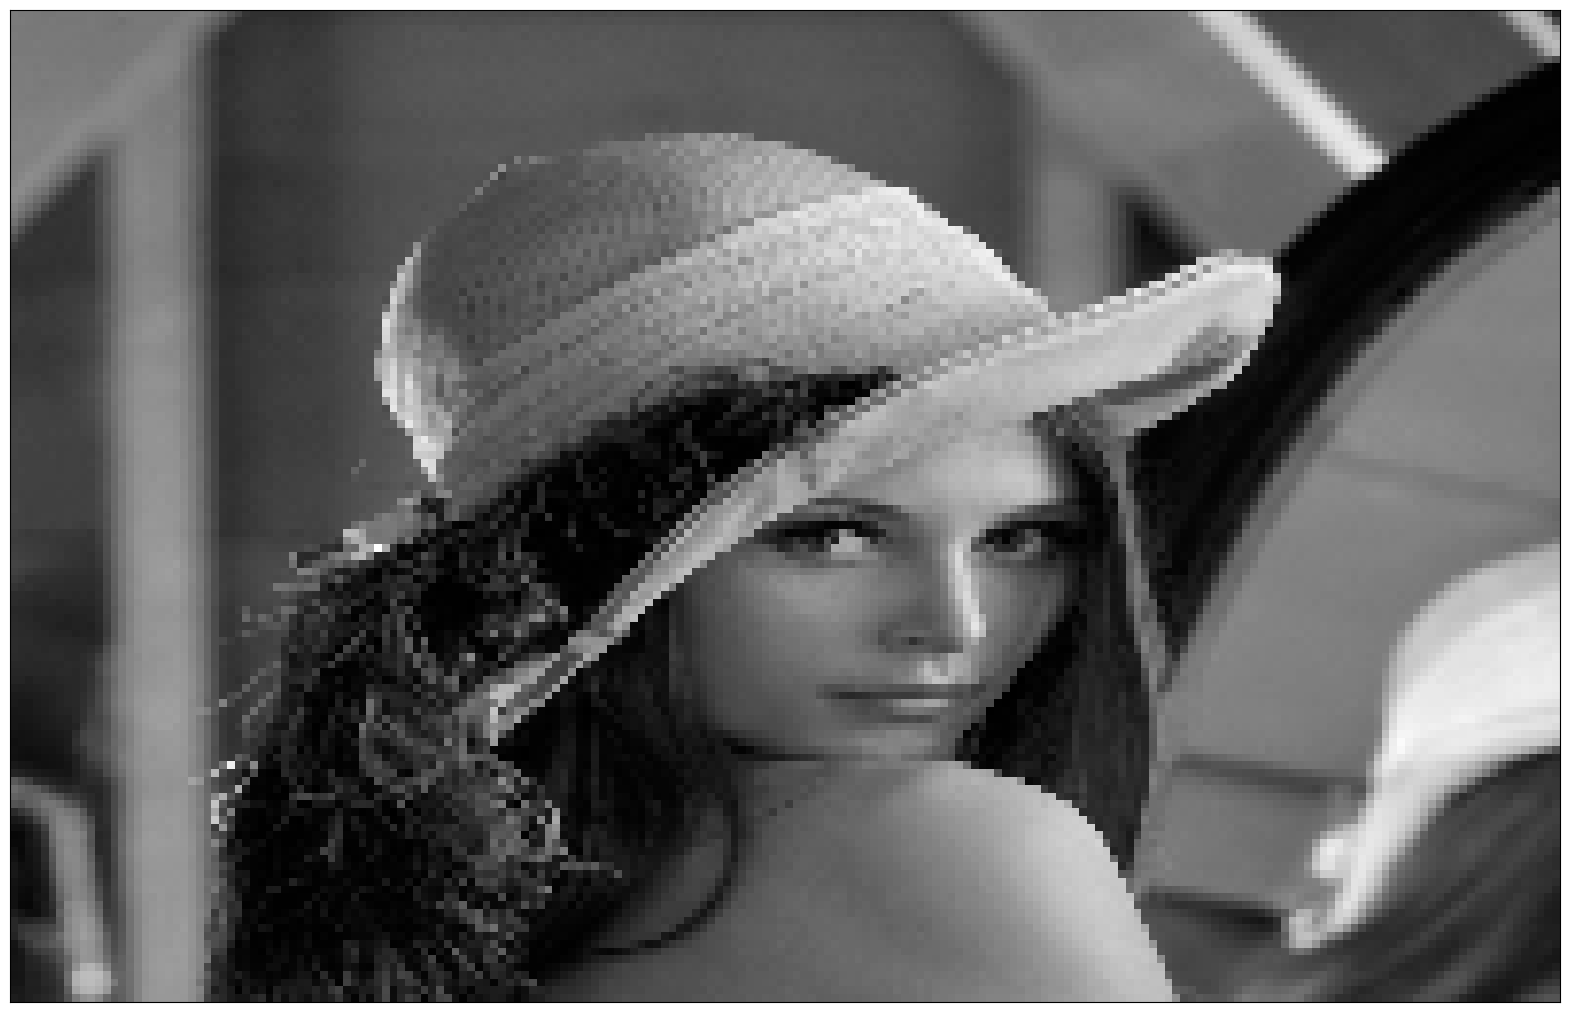

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.imshow(rec[4,:,:], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()


<class 'torch.Tensor'> 1 0
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 2
<class 'torch.Tensor'> 1 3
<class 'torch.Tensor'> 2 0
<class 'torch.Tensor'> 2 1
<class 'torch.Tensor'> 2 2
<class 'torch.Tensor'> 2 3
<class 'torch.Tensor'> 3 0
<class 'torch.Tensor'> 3 1
<class 'torch.Tensor'> 3 2
<class 'torch.Tensor'> 3 3
<class 'numpy.ndarray'> 1 0
<class 'numpy.ndarray'> 1 1
<class 'numpy.ndarray'> 1 2
<class 'numpy.ndarray'> 1 3
<class 'numpy.ndarray'> 2 0
<class 'numpy.ndarray'> 2 1
<class 'numpy.ndarray'> 2 2
<class 'numpy.ndarray'> 2 3
<class 'numpy.ndarray'> 3 0
<class 'numpy.ndarray'> 3 1
<class 'numpy.ndarray'> 3 2
<class 'numpy.ndarray'> 3 3


/home/jonathanalis/.local/lib/python3.10/site-packages/torch/_tensor.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


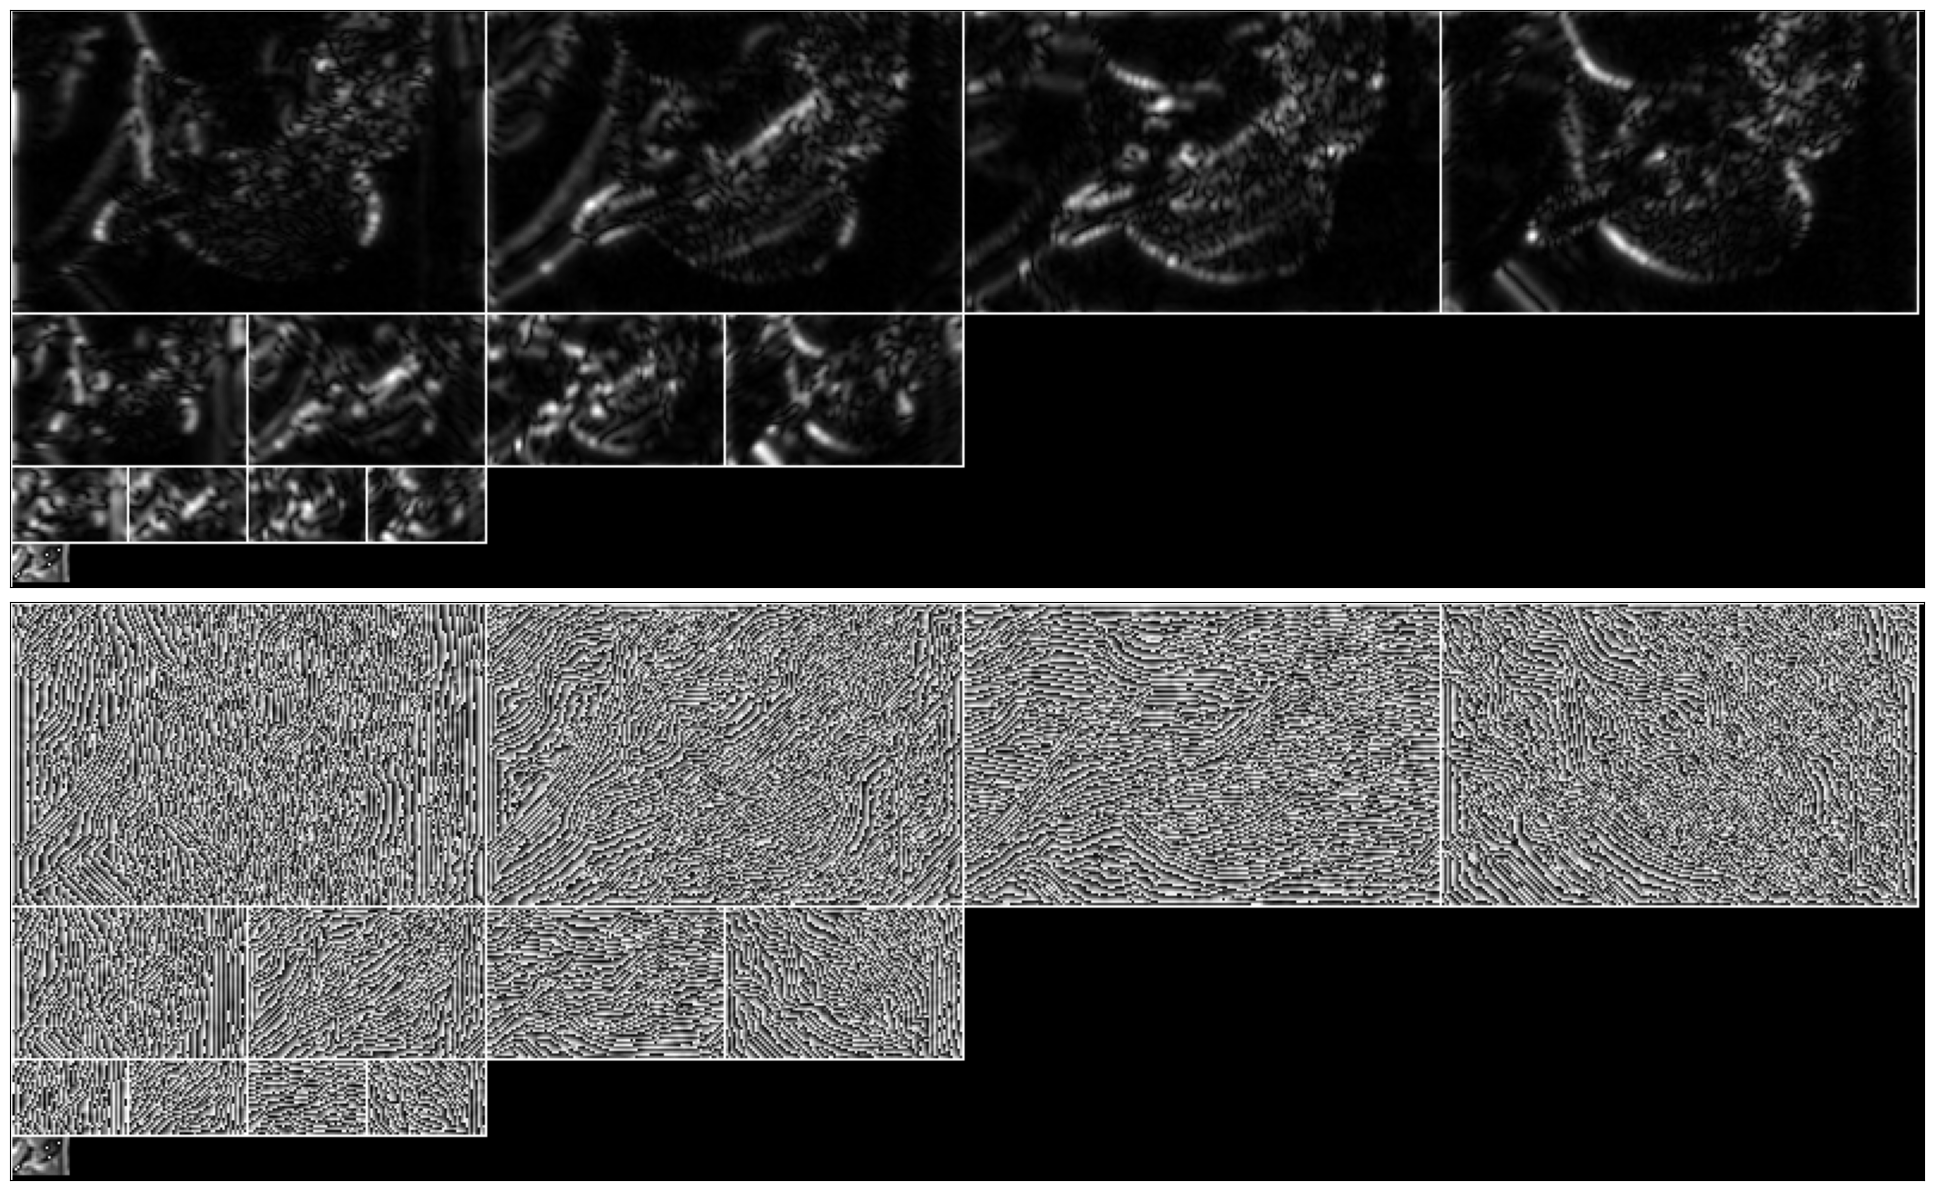

In [7]:
#coeff_grid_real = pyr.view_coeff(coeffs, part = 'real', normalize=True)
#coeff_grid_imag = pyr.view_coeff(coeffs, part = 'imag', normalize=True)
coeff_grid_mag = pyr.view_coeff(coeffs, part = 'mag', normalize=True)
coeff_grid_phase = pyr.view_coeff(coeffs, part = 'phase', normalize=True)

num_plots = 2
aspect_ratio = coeff_grid_phase.shape[1]/coeff_grid_phase.shape[0]
fig, axs = plt.subplots(num_plots, 1, figsize=(20, int(num_plots*20/aspect_ratio)))
axs[0].imshow(coeff_grid_mag, cmap='gray')
axs[1].imshow(coeff_grid_phase, cmap='gray')
#axs[2].imshow(coeff_grid_real, cmap='gray')
#axs[3].imshow(coeff_grid_imag, cmap='gray')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()
